In [2]:
# Import modules.
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
import xlrd
import xlsxwriter
import itertools
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0
from matplotlib.ticker import FormatStrFormatter

In [3]:
# Define helper functions.
def scatter_hist(x, y, ax, ax_histx, ax_histy, color=plt.cm.twilight(0.5)):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker=".", color=plt.cm.twilight(0.5), s=2, edgecolor=None, alpha=0.6)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color=plt.cm.twilight(0.5), alpha=0.6, density=True)
    ax_histy.hist(y, bins=100, orientation='horizontal', color=plt.cm.twilight(0.5), alpha=0.6, density=True)

In [23]:
# Generate data.
n_points = 30
noise = np.random.normal(0, 1, n_points)
x = np.random.uniform(20, 100, n_points)
y = 0.2 * x + 3 + noise

In [25]:
# Define model.
with pm.Model() as linear_model:
    
    # Define priors.
    alpha = pm.Normal("slope", mu=0, sigma=1e6)
    beta = pm.Normal("intercept", mu=0, sigma=1e6)
    
    # Define posterior.
    y_obs = pm.Normal("y_obs",
                mu=x * alpha + beta,
                observed=y)
    
    # Sample.
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(2000, tune=2000, init="adapt_diag")
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3596.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 8000/8000 [00:05<00:00, 1495.96it/s]


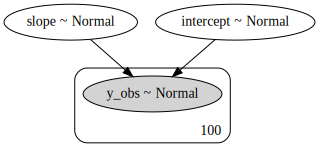

In [6]:
# Visualize graphical model.
pm.model_graph.model_to_graphviz(linear_model)

In [26]:
pm.stats.summary(posterior, credible_interval=0.94)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
slope,0.194,0.007,0.18,0.208,0.000,0.000,1781.0,1781.0,1772.0,1864.0,1.0
intercept,3.333,0.472,2.45,4.211,0.011,0.008,1760.0,1743.0,1762.0,2028.0,1.0


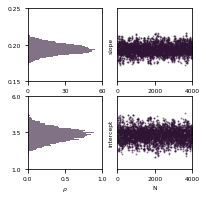

In [27]:
# Plot traces.
n_v = len(posterior.varnames)
limits_x = [(0.0, 60.0), (0.0, 1.0)]
limits_y = [(0.15, 0.25), (1, 6)] 
labels = ["", "", ""]
fig, axes = plt.subplots(figsize=(2.95, 0.5*n_v*2.95), ncols=2, nrows=n_v)
ax = axes.ravel()
for k in range(n_v):
    ax[2*k].hist(posterior[posterior.varnames[k]], orientation="horizontal", density=True, bins=50, color=plt.cm.twilight(0.5), alpha=0.6)
    ax[2*k+1].plot(posterior[posterior.varnames[k]], ".", ms=2, color=plt.cm.twilight(0.5), alpha=0.4)
    ax[2*k+1].set_ylabel(posterior.varnames[k].lower())
    ax[2*k+1].set_yticks(())
    ax[2*k+1].set_xlim((0, 4000))
    ax[2*k+1].set_xticks((0, 2000, 4000))
    ax[2*k].set_xlim(limits_x[k])
    ax[2*k].set_xticks(np.linspace(limits_x[k][0], limits_x[k][1], 3))
    ax[2*k].set_ylim(limits_y[k])
    ax[2*k].set_yticks(np.linspace(limits_y[k][0], limits_y[k][1], 3))
    ax[2*k+1].set_ylim(limits_y[k])
    #ax[2*k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2*k].set_xlabel(r"$\rho$")
ax[2*k+1].set_xlabel(r"N")
plt.savefig('./figures/parameter_sampling',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

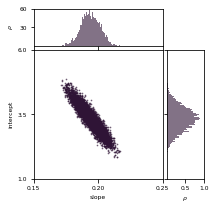

In [28]:
# Plot parameter distribution.
fig = plt.figure(figsize=(1.0*2.95, 1.0*2.95))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_xlim(0.15, 0.25)
ax.set_ylim(1, 6)
ax.set_xlabel(posterior.varnames[0].lower())
ax.set_ylabel(posterior.varnames[1].lower())

ax.set_yticks((1, 3.5, 6))
ax.set_xticks((0.15, 0.20, 0.25))

ax_histx.set_ylim(0, 60)
ax_histx.set_yticks((30, 60))
ax_histx.set_ylabel(r"$\rho$")

ax_histy.set_xlim(0.0, 1)
ax_histy.set_xticks((0.5, 1))
ax_histy.set_xlabel(r"$\rho$")

scatter_hist(posterior[posterior.varnames[0]], posterior[posterior.varnames[1]], ax, ax_histx, ax_histy, color=plt.cm.twilight(0.5))
plt.savefig('./figures/parameter_scatter',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

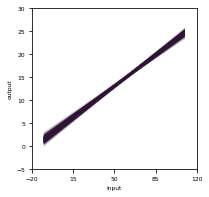

In [29]:
# Plot predictions (with uncertainty).
def linear_model(posterior, x):
    return posterior["slope"] * x + posterior["intercept"]

lm = lambda x, samples: linear_model(samples, x)

plt.figure(figsize=(2.95, 2.95))
pm.plot_posterior_predictive_glm(posterior, eval=np.linspace(-10, 110, 500), 
                                 lm=lm, samples=1000, lw=0.2, color=plt.cm.twilight(0.5), alpha=0.15)
plt.title(label=None)
plt.xlabel(r"input")
plt.ylabel(r"output")
plt.xlim((-20, 120))
plt.xticks(np.linspace(-20, 120, 5))
plt.ylim((-5, 30))
plt.savefig('./figures/prediction', dpi=900, transparent=True, orientation='landscape', bbox_inches='tight')
plt.show()

The median is 32.42
The 94% credible interval is between 31.14 33.72


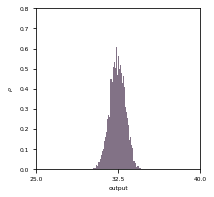

In [30]:
x = 150
y_pred = linear_model(posterior, x)

print("The median is", np.round(np.median(y_pred), 2))
print("The 94% credible interval is between", *np.round(pm.stats.hpd(y_pred, credible_interval=0.94), 2))

plt.figure(figsize=(2.95, 2.95))
plt.hist(y_pred, bins=100, density=True, color=plt.cm.twilight(0.5), alpha=0.6)
plt.xlim(25, 40)
plt.xticks(np.linspace(25, 40, 3))
plt.ylim(0, 0.8)
plt.xlabel(r"output")
plt.ylabel(r"$\rho$")
plt.savefig('./figures/prediction_new_sample',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()